In [1]:
# Calculating the field in a levitator using the matrix method discussed in 
# Andrade et al. ''Matrix method for acoustic levitation simulation''
# May help for optimizing parameters in our levitator,
#  especially curvature radius of the reflector 

## _v1: using meshgrids instead of lists of points restricts geometries of transducer/reflector

import numpy as np
import pylab as plt
import numpy.ma as ma
from mpl_toolkits import mplot3d
from time import time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt


0.02198052406311035
92.02714848518372
3.123283386230469e-05


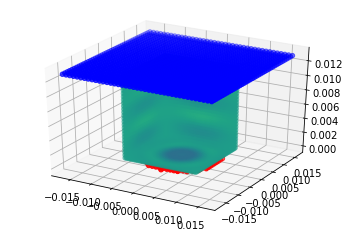

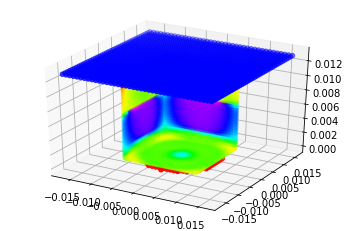

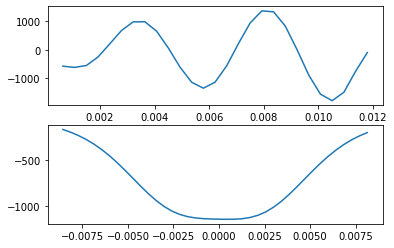

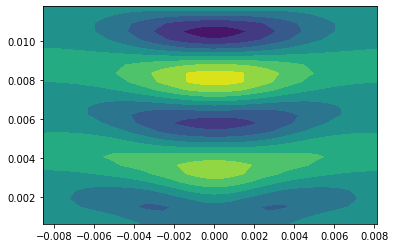

In [18]:
# Constants
freq = 40000
omega = 2*np.pi*freq
c = 343
wavel = c/freq
k = 2 * np.pi/wavel
rho = 1 
a = 10**(-3)

# Initialize the grid of points representing the transducer
def grid_circle(R,d,z0):
    x_points = np.arange(-R,R,d)
    y_points = np.arange(-R,R,d)
    z_points = z0
    xg, yg, zg= np.meshgrid(x_points,y_points,z_points)
    r = np.sqrt(xg**2+yg**2)
    outside = r>R
    xg,yg,zg = ma.masked_array(data=(xg,yg,zg),mask=(outside,outside,outside)) 
    return ma.stack((xg,yg,zg))

# Planar reflector
def grid_rectangle(Rx,Ry,d,z0):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    z_points = z0
    xg, yg, zg= np.meshgrid(x_points, y_points, z_points)
    return np.stack((xg, yg, zg))

# Planar reflector with tilt
def grid_tilt(Rx,Ry,d,z0,theta):
    x_points = np.arange(-Rx,Rx,d)
    y_points = np.arange(-Ry,Ry,d)
    xg, yg= np.meshgrid(x_points, y_points)
    zg = z0+ xg*np.tan(theta)
    return np.stack((xg, yg, zg))

# Target points (internal volume)
def field_points(Rx,Ry,Rz,d,x0,y0,z0):
    x_points = np.arange(-Rx,Rx,d) + x0
    y_points = np.arange(-Ry,Ry,d) + y0
    z_points = np.arange(-Rz,Rz,d) + z0
    xg,yg,zg = np.meshgrid(x_points,y_points,z_points)
    return np.stack((xg, yg, zg))

def transfer(source,target):
    dx = target[0,:,:,:,None,None,None] - source[0,None,None,None:,:,:]
    dy = target[1,:,:,:,None,None,None] - source[1,None,None,None:,:,:]
    dz = target[2,:,:,:,None,None,None] - source[2,None,None,None:,:,:]
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    source_area = d_t**2 # area represented per gridpoint, currently only works for constant z surfaces
    return source_area * (np.exp(-1j*k*r))/r

def transducer_output(grid_points, amplitude, phase):
    xg,yg,zg = grid_points[0,:,:,:] , grid_points[1,:,:,:], grid_points[2,:,:,:]
    output = np.ones(np.shape(xg),dtype='complex') * amplitude * np.exp(1j*phase)
    return output

d_t = wavel/10
d_r = wavel/10
d_f = wavel/20
R_t = wavel
R_r = wavel*2
R_f = R_t
H = wavel*(3/2)
transducer = grid_circle(R_t,d_t,0)
reflector = grid_rectangle(R_r,R_r,d_r,H)
# reflector = grid_tilt(R_r,R_r,d_r,H,(10/180)*np.pi)
field = field_points(R_f,R_f,H/2*.9,d_f,0,0,H/2) # start sampling just above transducer to avoid diverging pressure at transducer face
U = transducer_output(transducer, 1, 0)


TTM = transfer(transducer,field) # Transfer Transducer (to) Measurement points (field)
TRM = transfer(reflector,field) # Reflector to Measurement points
TTR = transfer(transducer,reflector) # Transducer to Reflector
TRT = transfer(reflector,transducer) # Reflector to Transducer

pref1 = omega*rho*c/wavel
pref2 = 1j/wavel


time1 = time()
term1 = np.einsum('ijklmn,lmn',TTM, U)
print(time()-time1)
time2 = time()
term2 = pref2 * np.einsum('abcijk,ijklmn,lmn',TRM,TTR,U)
print(time()-time2)
time3 = time()
#term3 = pref2**2 * np.einsum('abclmn,lmnijk,ijklmn,lmn' ,TTM,TRT,TTR,U)
print(time()-time3)
# term4 = pref1 * pref2**3 * np.einsum('ijklmn,ijklmn,ijklmn,ijklmn,lmn',TRM,TTR,TRT,TTR,U)
# term5 = pref1 * pref2**4 * np.einsum('ijklmn,ijklmn,ijklmn,ijklmn,ijklmn,lmn',TTM,TRT,TTR,TRT,TTR,U)
pressure = pref1*(term1 +term2)# + term3)# +term4 + term5
velocity = np.gradient(-pressure/(1j*omega*rho), d_f)
pressure_squared = pressure*np.conjugate(pressure)
velocity_squared = np.einsum('aijk,aijk->ijk',velocity,np.conjugate(velocity))

potential = np.real( 2*np.pi*a**3 *(pressure_squared/(3*rho*c**2) - rho*velocity_squared/2) )

amplitude = np.abs(pressure)
phase = np.angle(pressure)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(transducer[0,:,:,:], transducer[1,:,:,:],transducer[2,:,:,:],color='r')
ax.scatter(reflector[0,:,:,:], reflector[1,:,:,:],reflector[2,:,:,:],color='blue')
ax.scatter(field[0,:,:,:], field[1,:,:,:],field[2,:,:,:],c=np.ravel(potential),alpha=.5)

fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(transducer[0,:,:,:], transducer[1,:,:,:],transducer[2,:,:,:],color='r')
ax2.scatter(reflector[0,:,:,:], reflector[1,:,:,:],reflector[2,:,:,:],color='blue')
ax2.scatter(field[0,:,:,:], field[1,:,:,:],field[2,:,:,:],c=np.ravel(phase),alpha=.5,cmap='hsv')

midX = int(len(field[2,:,0,0])/2)
midY = int(len(field[2,0,:,0])/2)
midZ = int(len(field[2,0,0,:])/2)
fig, ax = plt.subplots(nrows=2)
ax[0].plot(field[2,midX,midY,:],potential[midX,midY,:])
ax[1].plot(field[1,:,midY,midZ],potential[:,midY,midZ])

fig, ax =plt.subplots()
ax.contourf(field[1,:,midY,:],field[2,:,midY,:],potential[:,midY,:])

In [16]:
Rx = 1
Ry = 1 
d = .1
z0 = 1
theta = (10/180)*np.pi
x_points = np.arange(-Rx,Rx,d)
y_points = np.arange(-Ry,Ry,d)
z_points = np.arange(-Rx*np.tan(theta),Rx*np.tan(theta),d)
xg, yg,zg= np.meshgrid(x_points, y_points,z_points)

np.shape(yg)

(20, 20, 4)